In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from scipy import interp
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from math import e
%matplotlib inline

In [7]:
class logit:
    def __init__(self):
        self.w = None
        self.train_cost = []
        self.test_cost = []
        self.e = None
        self.stopcriteria=1e-06
    def sigmoid(self, z):
        return 1 / (1 + e**(-z))
    
    def gradient(self, x, y):
        y_hat = self.sigmoid(x.dot(self.w))
        return (1/len(y)) * x.T.dot(y_hat - y)
    
    def cost(self, X, Y):
        Y_hat = self.sigmoid(X.dot(self.w))
        cost = - Y.T.dot(np.log(Y_hat)) - (1-Y).T.dot(np.log(1- Y_hat))
        return cost / len(Y)
    
    def fit(self, x_train, y_train, x_test, y_test, lr, epoch=500):
        # initialize weight
        self.w = np.random.rand(x_train.shape[1])
        
        self.e = 0
        while self.e <= epoch:
            current_w = self.w
            # cost
            c_train = self.cost(X=x_train, Y=y_train)
            c_test = self.cost(X=x_test, Y=y_test)
            self.train_cost.append(c_train)
            self.test_cost.append(c_test)
            # training
            y_hat = self.sigmoid(x_train.dot(self.w))
            grad = self.gradient(x_train, y_train)
            self.w = current_w - lr * grad
            
            self.e += 1
            #Stopping critieria
            if self.e!=0 and np.abs(np.linalg.norm(self.w,ord=2)-np.linalg.norm(current_w, ord=2))<self.stopcriteria:
                break
            pass
        pass
    
    def predict(self, x):
        return self.sigmoid(x.dot(self.w))

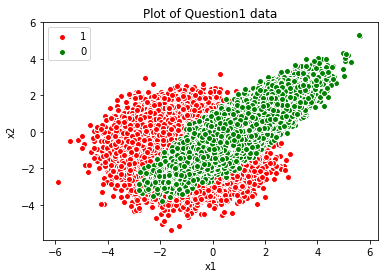

In [9]:
data=pd.read_csv("./A3_Q1_data.csv")
x = data[["x1", "x2"]].values
y = data["y"].values
y1_class = plt.scatter(x[y == 1, 0], x[y == 1, 1], c="r", edgecolors="white",label = "1")
y2_class = plt.scatter(x[y == 0, 0], x[y == 0, 1], c="g", edgecolors="white",label = "0")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Plot of Question1 data")
plt.legend()
plt.show()


It looks like the dataset is not completely linearly separable as there are some overlappings around (0,0). The decision boundary is not linear and logistic regression might not be able to efficiently classify the data.

In [10]:
print("Based on the tables below, there is no missing value in the dataset.")
print("For normalization problem, as the scales across different columns are different, the normalization should be applied.")
print("Number of missing values in the dataset by column")
print("**************************************************")
print(data.isnull().sum())
print("**************************************************")
print(data.describe())
print("**************************************************")

Based on the tables below, there is no missing value in the dataset.
For normalization problem, as the scales across different columns are different, the normalization should be applied.
Number of missing values in the dataset by column
**************************************************
x1    0
x2    0
y     0
dtype: int64
**************************************************
                  x1             x2              y
count  100000.000000  100000.000000  100000.000000
mean        0.048529      -0.397106       0.500000
std         1.452409       1.164015       0.500003
min        -5.886436      -5.352265       0.000000
25%        -1.041007      -1.206343       0.000000
50%         0.039551      -0.401099       0.500000
75%         1.143536       0.402899       1.000000
max         5.634476       5.317718       1.000000
**************************************************


In [13]:
#normalize data
Q1_scaler=StandardScaler()
data.loc[:,['x1','x2']] = Q1_scaler.fit_transform(data.loc[:,['x1','x2']])
data.describe()

,x1,x2,y
count,1.000000e+05,1.000000e+05,100000.000000
mean,9.232615e-18,-4.213296e-17,0.500000
std,1.000005e+00,1.000005e+00,0.500003
min,-4.086311e+00,-4.256975e+00,0.000000
25%,-7.501616e-01,-6.952156e-01,0.000000
50%,-6.181174e-03,-3.430496e-03,0.500000
75%,7.539289e-01,6.872842e-01,1.000000
max,3.846008e+00,4.909603e+00,1.000000


In [16]:
# split data
np.random.shuffle(np.arange(len(y)))
x_train=x[:70000]
y_train=y[:70000]
x_test=x[70000:]
y_test=y[70000:]

#adding bias terms
x_train = np.column_stack((np.ones(len(x_train)),x_train))
x_test = np.column_stack((np.ones(len(x_test)),x_test))

In [17]:
logreg = logit()
logreg.fit(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, lr = 0.1)

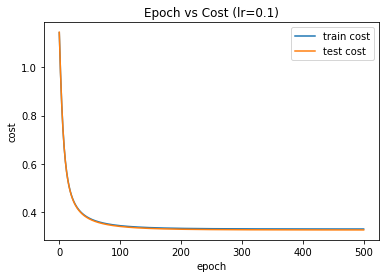

In [18]:
l_train, = plt.plot(range(logreg.e), logreg.train_cost, label = "train cost")
l_test, = plt.plot(range(logreg.e), logreg.test_cost, label = "test cost")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.title("Epoch vs Cost (lr=0.1)")
plt.legend(handles=[l_train, l_test])
plt.show()

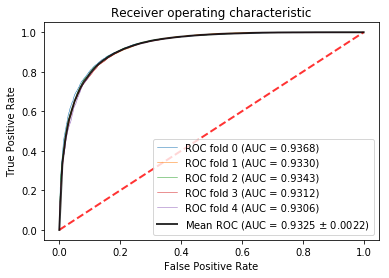

In [21]:
skf = StratifiedKFold(n_splits=5)
i = 0
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
#plt.figure(figsize=(6, 6))
for train_index, validation_index in skf.split(x_train, y_train):
    x_train_, x_validation = x_train[train_index], x_train[validation_index]
    y_train_, y_validation = y_train[train_index], y_train[validation_index]
    
    logreg_cv = logit()
    logreg_cv.fit(x_train=x_train_, y_train=y_train_, x_test=x_validation, y_test=y_validation, lr = 3)
    
    y_val_hat = logreg_cv.predict(x_validation)
        
    fpr, tpr, _ = metrics.roc_curve(y_validation, y_val_hat)
    roc_auc = metrics.auc(fpr, tpr)
    
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr, tpr, lw=0.5, alpha=1,
             label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
    i += 1
    pass
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black',
         label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


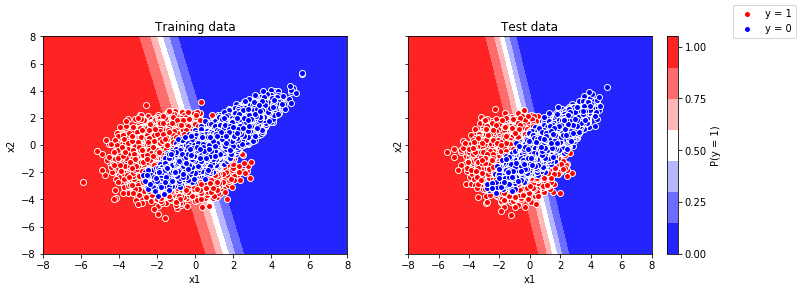

In [25]:
x1 = np.linspace(-8, 8, 300)
x2 = np.linspace(-8, 8, 300)

x1v, x2v = np.meshgrid(x1, x2)

X_mesh = np.column_stack((np.ones(len(x1v.ravel())), x1v.ravel(), x2v.ravel()))
y_hat_mesh = logreg.predict(X_mesh)

logreg = logit()
logreg.fit(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, lr = 5)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
ax1.contourf(x1v, x2v, y_hat_mesh.reshape(x1v.shape), cmap="bwr")
ax1.scatter(x = x_train[y_train == 1,1], y = x_train[y_train == 1,2], c='r', edgecolors="white", label = "y = 1")
ax1.scatter(x = x_train[y_train == 0,1], y = x_train[y_train == 0,2], c='b', edgecolors="white", label = "y = 0")
ax1.set_xlim(x1v.min(), x1v.max())
ax1.set_ylim(x2v.min(), x2v.max())
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_title("Training data")

c2 = ax2.contourf(x1v, x2v, y_hat_mesh.reshape(x1v.shape), cmap="bwr")
ax2.scatter(x = x_test[y_test == 1,1], y = x_test[y_test == 1,2], c='r', edgecolors="white")
ax2.scatter(x = x_test[y_test == 0,1], y = x_test[y_test == 0,2], c='b', edgecolors="white")
ax2.set_xlim(x1v.min(), x1v.max())
ax2.set_ylim(x2v.min(), x2v.max())
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_title("Test data")
cb = f.colorbar(c2)
cb.set_label("P(y = 1)")
cb.set_ticks([0, .25, .5, .75, 1])
f.legend()
f.show()

The decision boundry does not separate the data precisely. It could be enhanced through transformations on data, such as quadratic terms. Furthermore, it would produce much more enhancements through changing classification methods.

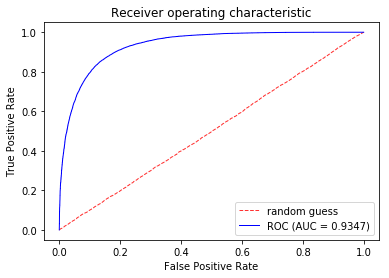

logreg_auc :  0.93
random_auc :  0.5
As we can see, our model outperforms the random guess a lot in terms of AUC.


In [26]:
#Compare the trained model to random guessing. Show the ROC curve for your model and plot the chance diagonal. 
#What area under the curve (AUC) does your model achieve? 
#How does your model compare in terms of performance?

y_rand = np.random.rand(y_test.shape[0],1)
fpr1, tpr1, _  = metrics.roc_curve(y_test,y_rand, pos_label=1)
y_test_hat = logreg.predict(x_test)
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_test_hat)

logreg_auc = metrics.auc(fpr2, tpr2)
random_auc=metrics.auc(fpr1,tpr1)
plt.plot(fpr1, tpr1, lw=1, alpha=.8, color='r',linestyle='--',label='random guess')
plt.plot(fpr2, tpr2, lw=1, alpha=1, color='b',label='ROC (AUC = %0.4f)' % (logreg_auc))

plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()
print("logreg_auc : ",round(logreg_auc,2))
print("random_auc : ",round(random_auc,2))
print("As we can see, our model outperforms the random guess a lot in terms of AUC.")